In [1]:
import pandas as pd
import altair as alt
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from scipy.stats import shapiro, mannwhitneyu, spearmanr
from scipy import stats
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv(override=True)

True

## MongoDB

In [2]:
# Create a class for saving to mongoDB for better reuse
def save_to_mongo(final_json, collection):
    uri = os.getenv("MONGODB_URI")
    client = MongoClient(uri, server_api=ServerApi('1'))
    try:
        db = client["data"]
        collection = db[collection]
        if final_json:
            collection.insert_one(final_json)
        else:
            print("No documents to insert.")
    except Exception as e:
        print(e)

In [3]:
def read_mongo(collection, is_duplicates, metric):
    uri = os.getenv("MONGODB_URI")
    client = MongoClient(uri, server_api=ServerApi('1'))
    try:
        db = client["data"]
        collection = db[collection]
        document = collection.find_one({"model":"cis", "is_duplicates":is_duplicates, "metric":metric})
        return document
    except Exception as e:
        # TODO: Add error handling
        print(e)

## Convert to DataFrame

In [4]:
def to_metric_df(json_obj, metric_name, context_cols=('reference','response')):
    rows = []
    
    # ...Your data format, assume one dict per json file, as in prior examples
    model = json_obj['model']
    is_duplicates = json_obj['is_duplicates']
    for q_key in [k for k in json_obj if k.startswith('question_')]:
        # TODO: remove if when ready
        if q_key == 'question_1':
            for resp in json_obj[q_key]:
                rows.append({
                    'model': model,
                    'is_duplicates': is_duplicates,
                    'question_group': q_key,
                    context_cols[0]: resp['reference'],
                    context_cols[1]: resp['response'],
                    metric_name: resp['score']
                })
    return pd.DataFrame(rows)

In [5]:
def create_df_combined(is_duplicates):
    # List of (metric_name_in_db, df_col_name, optional: extra to_metric_df args)
    metrics = [
        ("BlueScore", "Bleu Score"),
        ("Rouge Score", "Rouge Score"),
        ("Non-LLM String Similarity", "Non-LLM String Similarity"),
        ("LLM Semantic Similarity", "LLM Semantic Similarity"),
        ("ExactMatch", "Exact Match", ('reference_context', 'response_context')),
    ]

    dfs = []
    join_cols = ['model', 'is_duplicates', 'question_group', 'reference', 'response']
    join_exact = ['model', 'is_duplicates', 'question_group']

    for metric in metrics:
        # Always first two
        metric_db, metric_col = metric[0], metric[1]
        json_data = read_mongo("partial_results", is_duplicates, metric_db)
        # Optionally pass extra args for to_metric_df
        if len(metric) > 2:
            df = to_metric_df(json_data, metric_col, metric[2])
            cols_to_drop = join_exact
        else:
            df = to_metric_df(json_data, metric_col)
            cols_to_drop = join_cols
        # Only drop for other than first df
        if metric != metrics[0]:
            df = df.drop(cols_to_drop, axis=1)
        # Always reset index
        dfs.append(df.reset_index(drop=True))

    df_combined = pd.concat(dfs, axis=1)

    # Add Consistency Score
    score_cols = [m[1] for m in metrics[:4]]  # Only first four are scores
    df_combined["Consistency Score"] = df_combined[score_cols].mean(axis=1)

    return df_combined

### Read datasets

In [6]:
duplicates = create_df_combined(True)
non_duplicates = create_df_combined(False)

### Create Combined DF

In [7]:
# Combine the datasets
combined_df = pd.concat([duplicates.copy(), non_duplicates.copy()], ignore_index=True)
combined_df['Exact Match'] = pd.Categorical(combined_df['Exact Match'], categories=[0,1], ordered=True)
combined_df["dataset"] = combined_df["is_duplicates"].apply(lambda x: "Duplicates" if x else "Variants")
combined_df['dataset'] = pd.Categorical(combined_df['dataset'], categories=["Variants", "Duplicates"], ordered=True)

### Counting how many have exact match 1

In [8]:
# Count rows where Exact Match = 1 and dataset = "Duplicates"
count = len(combined_df[(combined_df['Exact Match'] == 1) & (combined_df['dataset'] == "Duplicates")])
print(f"duplicates: {count}")
count = len(combined_df[(combined_df['Exact Match'] == 1) & (combined_df['dataset'] == "Variants")])
print(f"variants: {count}")

duplicates: 28
variants: 16


### Counting how many have exact match 0

In [9]:
# Count rows where Exact Match = 1 and dataset = "Duplicates"
count = len(combined_df[(combined_df['Exact Match'] == 0) & (combined_df['dataset'] == "Duplicates")])
print(f"duplicates: {count}")
count = len(combined_df[(combined_df['Exact Match'] == 0) & (combined_df['dataset'] == "Variants")])
print(f"variants: {count}")

duplicates: 27
variants: 39


In [10]:
filtredf = combined_df[(combined_df['Exact Match'] == 1) & (combined_df['dataset'] == "Variants")]
print((filtredf['Consistency Score'].min()))
print((filtredf['Consistency Score'].median()))
print((filtredf['Consistency Score'].max()))

0.3831780220011257
0.47278171390470947
0.6871055648085105


### Save the avg_result correctly

In [11]:
def update_avg_result(is_duplicates:bool, is_context:bool, is_cis:bool, df:pd.DataFrame):
    final_json = {
        "is_duplicates": is_duplicates,
        "is_cis": is_cis,
        "is_context": is_context,
        "result": [
            {
                "model":"cis",
                "avg_score": df['Non-LLM String Similarity'].mean(),
                "metric": "Non-LLM String Similarity"
            },
            {
                "model":"cis",
                "avg_score": df['Bleu Score'].mean(),
                "metric": "BleuScore"
            },
            {
                "model":"cis",
                "avg_score": df['Rouge Score'].mean(),
                "metric": "Rouge Score"
            },
            {
                "model":"cis",
                "avg_score": df['LLM Semantic Similarity'].mean(),
                "metric": "LLM Semantic Similarity"
            },
        ]
    }
    print("Saving result to collection: avg_result")
    save_to_mongo(final_json, "avg_result")

## Correlation Analysis

### Check Normal Distribution 

In [12]:
shapiro(combined_df['Consistency Score'])

ShapiroResult(statistic=np.float64(0.8845768656132561), pvalue=np.float64(9.690981588903668e-08))

### Mann Whitney U + Rank-biserial Correlation

In [13]:
# Assuming your DataFrame is named df
scores_0 = duplicates.loc[duplicates['Exact Match'] == 0, 'Consistency Score']
scores_1 = duplicates.loc[duplicates['Exact Match'] == 1, 'Consistency Score']

U, p = mannwhitneyu(scores_0, scores_1, alternative='two-sided')
print(f"Mann-Whitney U statistic: {U}, p-value: {p}")

n0 = len(scores_0)
n1 = len(scores_1)
rank_biserial = 1 - (2 * U) / (n0 * n1)
print(f"Rank-biserial correlation: {rank_biserial:.3f}")

Mann-Whitney U statistic: 0.0, p-value: 2.0769151352345584e-10
Rank-biserial correlation: 1.000


In [14]:
def manwhit_rank_correlation(df):
    # Assuming your DataFrame is named df
    scores_0 = df.loc[df['Exact Match'] == 0, 'Consistency Score']
    scores_1 = df.loc[df['Exact Match'] == 1, 'Consistency Score']

    U, p = mannwhitneyu(scores_0, scores_1, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {U}, p-value: {p}")

    n0 = len(scores_0)
    n1 = len(scores_1)
    rank_biserial = 1 - (2 * U) / (n0 * n1)
    print(f"Rank-biserial correlation: {rank_biserial:.3f}\n")

In [15]:
print("Duplicates dataset:")
manwhit_rank_correlation(duplicates)
print("Non-Duplicates dataset:")
manwhit_rank_correlation(non_duplicates)
print("Combined dataset:")
manwhit_rank_correlation(combined_df)

Duplicates dataset:
Mann-Whitney U statistic: 0.0, p-value: 2.0769151352345584e-10
Rank-biserial correlation: 1.000

Non-Duplicates dataset:
Mann-Whitney U statistic: 204.0, p-value: 0.04635926001786432
Rank-biserial correlation: 0.346

Combined dataset:
Mann-Whitney U statistic: 624.0, p-value: 4.4430552713228454e-07
Rank-biserial correlation: 0.570



### Spearman Correlation

In [16]:
def spearman_correlation(df):
    # Compute Spearman correlation and p-value
    rho, pval = spearmanr(df['Consistency Score'], df['Exact Match'])

    print(f"Spearman's rho: {rho:.3f}, p-value: {pval:.5f}\n")

In [17]:
print("Duplicates dataset:")
spearman_correlation(duplicates)
print("Non-Duplicates dataset:")
spearman_correlation(non_duplicates)
print("Combined dataset:")
spearman_correlation(combined_df)

Duplicates dataset:
Spearman's rho: 0.866, p-value: 0.00000

Non-Duplicates dataset:
Spearman's rho: 0.272, p-value: 0.04426

Combined dataset:
Spearman's rho: 0.484, p-value: 0.00000



## Plots

### Bar Chart

In [18]:
def bar_chart(group, metric):    
    # Create a bar chart for the metric
    chart = alt.Chart(group).mark_bar().encode(
        x=alt.X('temperature:O', title='Temperature'),
        xOffset='dataset:N',  # Offset bars for different datasets
        y=alt.Y('avg_score:Q', title='Average Score', scale=alt.Scale(domain=[0,1])),
        color=alt.Color('dataset:N', title='Dataset', legend=alt.Legend(orient="top")),
        tooltip=['model', 'avg_score']
    ).properties(
        width=400,
        height=300,
        title=metric
    )

    return chart

### Scatter plot

In [34]:
def scatter_plot_datasets(df, y, group_col):
    # Prepare a list to collect per-group dataframes
    grouped_dfs = []

    # Process each exact match group separately
    for label, group in df.groupby(group_col, sort=False):
        group_sorted = group.sort_values(y)
        dens = stats.gaussian_kde(group_sorted[y])
        pdf = dens(group_sorted[y])
        density_cloud = np.array([np.random.uniform(0, v) for v in pdf])
        violin_cloud = density_cloud.copy()
        violin_cloud[::2] *= -1
        # Build a result DataFrame
        group_result = group_sorted.copy()
        group_result['density_cloud'] = density_cloud
        group_result['violin_cloud'] = violin_cloud
        grouped_dfs.append(group_result)

    df_with_density = pd.concat(grouped_dfs, axis=0)
    chart = alt.Chart(df_with_density).mark_circle().encode(
        x=alt.X('violin_cloud:Q')
                .title(None)
                .axis(labels=False, 
                      values=[0], 
                      grid=False, 
                      ticks=True,
                      labelFontSize=24,   # font size of tick labels
                      titleFontSize=24,   # font size of axis title
                    ),
        y=alt.Y(y).axis(
            labelFontSize=24,   # font size of tick labels
            titleFontSize=24,   # font size of axis title
        ),
        color=alt.Color(
            'dataset:N', 
            title='Dataset', 
            legend=alt.Legend(orient="top",labelFontSize=24,titleFontSize=24), 
            scale=alt.Scale(range=['#ff7000','#1e80ed'])),
    ).facet(
        column=alt.Column(group_col)
        .header(title='Exact Match', titleOrient='bottom', labelOrient='bottom', labelFontSize=24, titleFontSize=24)
    ).configure_facet(
        spacing=0
    ).configure_view(
        stroke=None
    )

    chart.display()

In [35]:
scatter_plot_datasets(
    df = combined_df.copy(),
    y = 'Consistency Score',
    group_col = 'Exact Match'
)

alt.FacetChart(...)

### Box Plot

#### SNS

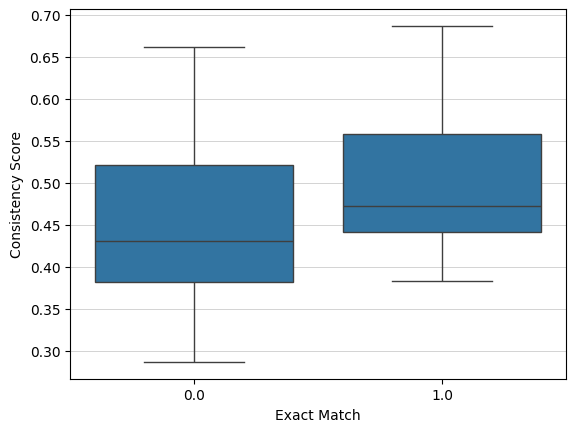

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.boxplot(x='Exact Match', y='Consistency Score', data=non_duplicates)
# Enable grid lines for y-axis (the "back axes lines")
ax.grid(True, which='major', axis='y', linewidth=0.7, color='lightgray')
plt.show()
sns.boxplot(x='Exact Match', y='Consistency Score', data=duplicates)
plt.show()

#### Alt

In [22]:
def box_plot(df: pd.DataFrame):
    min_y = df['Consistency Score'].min()
    max_y = df['Consistency Score'].max()    
    # Create a bar chart for the metric
    chart = alt.Chart(df).mark_boxplot(
        size=200, 
        rule={'strokeWidth': 2, 'color': 'black'}, # Make whiskers thicker and black
        # Customize the median line
        median={'strokeWidth': 3, 'color': 'red'}, # Make median line thicker and red for distinction
    ).encode(
        x=alt.X('Exact Match:O', title='Exact Match'),
        y=alt.Y('Consistency Score:Q', title='Consistency Score', scale=alt.Scale(domain=[min_y-0.05,max_y+0.05])),
        color=alt.Color('Exact Match:O', title='Exact Match', legend=None, scale=alt.Scale(scheme='paired')),
        tooltip=['Consistency Score']
    ).properties(
        width=500,
        height=450,
        title='Experiment'
    )

    chart.display()

In [23]:
box_plot(duplicates)
box_plot(non_duplicates)

alt.Chart(...)

alt.Chart(...)

### Violin Plot

#### SNS

In [24]:
print(combined_df[combined_df['Consistency Score'] > 1.0])

Empty DataFrame
Columns: [model, is_duplicates, question_group, reference, response, Bleu Score, Rouge Score, Non-LLM String Similarity, LLM Semantic Similarity, reference_context, response_context, Exact Match, Consistency Score, dataset]
Index: []


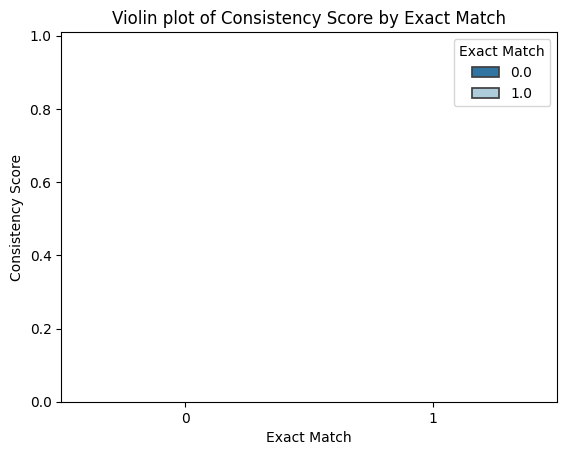

In [25]:
# Optionally make 'Exact Match' a string so x-axis is categorical
combined_df['Exact Match'] = combined_df['Exact Match'].astype(str)

sns.violinplot(
    data=duplicates,
    x="Exact Match",
    y="Consistency Score",
    palette=["#1f78b4", "#a6cee3"],
    hue="Exact Match",
    order=["0", "1"]
)
plt.title("Violin plot of Consistency Score by Exact Match")
plt.ylim(0, 1.01)
plt.show()

#### Alt

##### Based on Exact Match

In [26]:
# Create a violin plot using Altair
def violin_plot(data):
    chart = alt.Chart(data, width=200).transform_density(
        'Consistency Score',
        as_=['Consistency Score', 'density'],
        groupby=['Exact Match']
    ).mark_area(orient='horizontal').encode(
        alt.X('density:Q')
            .stack('center')
            .impute(None)
            .title(None)
            .axis(labels=False, values=[0], grid=False, ticks=True),
        alt.Y('Consistency Score:Q'),
        alt.Color('Exact Match:N', title='Exact Match'),
        alt.Column('Exact Match:N')
            .spacing(0)
            .header(title='Exact Match', titleOrient='bottom', labelOrient='bottom', labelPadding=0)
    ).configure_view(
        stroke=None
    ).properties(
        height=350,
        title='Distribution of Consistency Scores'
    )
    
    chart.display()


In [27]:
exact_filter_0 = duplicates[duplicates["Exact Match"] == 0].copy()
exact_filter_1 = duplicates[duplicates["Exact Match"] == 1].copy()

In [28]:
exact_filter_0.head()

model  is_duplicates question_group  \
1    cis           True     question_1   
3    cis           True     question_1   
6    cis           True     question_1   
10   cis           True     question_1   
12   cis           True     question_1   

                                            reference  \
1   \nTo enhance the security of file uploads in t...   
3   \nTo enhance the security of file uploads in t...   
6   \nTo enhance the security of file uploads in t...   
10  \nTo enhance the security of file uploads in t...   
12  \nTo enhance the security of file uploads in t...   

                                             response  Bleu Score  \
1   \nTo enhance the security of file uploads in t...    0.774786   
3   \nTo enhance the security of file uploads in t...    0.774786   
6   \nTo enhance the security of file uploads in t...    1.000000   
10  \nTo enhance the security of file uploads in t...    0.774786   
12  \nTo enhance the security of file uploads in t...    0.774786   

    Rouge Score  Non-LLM String Similarity  LLM Semantic Similarity  \
1      0.722772                   0.666203                 0.985138   
3      0.590909                   0.545260                 0.974274   
6      0.382143                   0.305970                 0.861914   
10     0.722772                   0.666203                 0.985275   
12     0.590909                   0.545260                 0.974282   

                                    reference_context  \
1   Source: CountYourWords/src\n```\nNone\n```\nSo...   
3   Source: CountYourWords/src\n```\nNone\n```\nSo...   
6   Source: CountYourWords/src\n```\nNone\n```\nSo...   
10  Source: CountYourWords/src\n```\nNone\n```\nSo...   
12  Source: CountYourWords/src\n```\nNone\n```\nSo...   

                                     response_context  Exact Match  \
1   Source: CountYourWords/src/test/textTests/vali...          0.0   
3   Source: CountYourWords/src/test/textTests/vali...          0.0   
6   Source: CountYourWords/src/test/textTests/vali...          0.0   
10  Source: CountYourWords/src/test/textTests/vali...          0.0   
12  Source: CountYourWords/src/test/textTests/vali...          0.0   

    Consistency Score  
1            0.787225  
3            0.721307  
6            0.637507  
10           0.787259  
12           0.721309

In [29]:
violin_plot(exact_filter_0)
violin_plot(exact_filter_1)

alt.Chart(...)

alt.Chart(...)

In [30]:
violin_plot(duplicates)

alt.Chart(...)

##### Based on Datasets

In [36]:
y_axis = alt.Y(
    'Consistency Score:Q',
    scale=alt.Scale(domain=[0, 1.005], nice=False),
    axis=alt.Axis(
		labelFontSize=24,   # font size of tick labels
		titleFontSize=24,   # font size of axis title
    )
)

boxplot = alt.Chart().mark_boxplot(color='black').encode(
	y=y_axis
).properties(width=200)

violin = alt.Chart().transform_density(
	'Consistency Score',
	as_=['Consistency Score', 'density'],
	extent=[0, 1.005],
	groupby=['Exact Match', 'dataset'],  # Include dataset in groupby
    bandwidth=0.06,
).mark_area(orient='horizontal').encode(
	y=y_axis,
	color=alt.Color('dataset:N', 
		title='Dataset', 
		legend=alt.Legend(orient="top"), 
        scale=alt.Scale(range=['#ff7000','#1e80ed']),
	),
	x=alt.X(
		'density:Q',
		stack='center',
		impute=None,
		title=None,
		scale=alt.Scale(nice=False,zero=False),
		axis=alt.Axis(
            labels=False, 
            values=[0], 
            grid=False, 
            ticks=True,
		),
	),
)

alt.layer(violin, boxplot, data=combined_df
	).properties(
        height=350
	).facet(
		column=alt.Column('Exact Match:N')
		.header(
			title='Exact Match', 
			titleOrient='bottom', 
			labelOrient='bottom', 
			labelPadding=5,
            labelFontSize=24,   # font size of tick labels
			titleFontSize=24,   # font size of axis title
   
		)
	).resolve_scale(
		x=alt.ResolveMode("independent"),
        y=alt.ResolveMode("shared")
	).configure_facet(
		spacing=0
	).configure_view(
		stroke=None
	).configure_legend(
        titleFontSize=20,
        labelFontSize=24,
    ).show()

alt.FacetChart(...)

#### Seperated shared axis

In [32]:
def violin_plot_shared():
    charts = []

    chart_duplicates = alt.Chart(duplicates, width=200).transform_density(
        'Consistency Score',
        as_=['Consistency Score', 'density'],
        groupby=['Exact Match'],
    ).mark_area(orient='horizontal').encode(
        x=alt.X('density:Q')
            .stack('center')
            .impute(None)
            .title(None)
            .axis(labels=False, values=[0], grid=False, ticks=True),
        y=alt.Y('Consistency Score:Q'),
        color=alt.Color('Exact Match:N', title='Exact Match'),
        column=alt.Column(
            'Exact Match:N',
            spacing=0,
            header=alt.Header(
                title='Exact Match',
                titleOrient='bottom',
                labelOrient='bottom',
                labelPadding=0
            )
        )
    )

    chart_non_duplicates = alt.Chart(non_duplicates, width=200).transform_density(
        'Consistency Score',
        as_=['Consistency Score', 'density'],
        groupby=['Exact Match'],
    ).mark_area(orient='horizontal').encode(
        x=alt.X('density:Q')
            .stack('center')
            .impute(None)
            .title(None)
            .axis(labels=False, values=[0], grid=False, ticks=True),
        y=alt.Y('Consistency Score:Q'),
        color=alt.Color('Exact Match:N', title='Exact Match'),
        column=alt.Column(
            'Exact Match:N',
            spacing=0,
            header=alt.Header(
                title='Exact Match',
                titleOrient='bottom',
                labelOrient='bottom',
                labelPadding=0
            )
        )
    )
    charts.append(chart_duplicates)
    charts.append(chart_non_duplicates)

    # Now set properties and configure globally
    final_chart = alt.hconcat(*charts).resolve_scale(y='independent').properties(
            title='shared axis'
        )
    final_chart.display()